In [1]:
import os, shutil

import xarray as xr
import dask.dataframe as dd

#from rechunker import rechunk
# need version 0.3.3, see: https://github.com/pangeo-data/rechunker/issues/92

%matplotlib inline
from matplotlib import pyplot as plt

import mitequinox.plot as pl
import mitequinox.utils as ut
import mitequinox.parcels as pa

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5579421.datarmor0/parcels-502090/libparcels_random_522a7b84-15f8-4081-ba47-f0bb91f41649.so


In [2]:
import pandas as pd
import numpy as np

In [3]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=3
                 )
#
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.0.72:44016 Dashboard: http://10.148.0.72:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
# output archives
out_dir = os.path.join("/home/datawork-lops-osi/equinox/mit4320/diags/", "ZC_california")
llc_zarr = os.path.join(out_dir, "llc.zarr")

parcels_index= 'time_mean'
parcels_name = "llc_parcels_"+parcels_index
parcels_path = os.path.join(out_dir, parcels_name)


In [6]:
ds = xr.open_zarr(llc_zarr)


In [109]:
ds_mean = ds.mean('time').compute()

dfE_mean = ds_mean.drop(['face']).to_dataframe()

In [110]:
import numpy as np
dl = 1.
lonmin,lonmax = dfE_mean.lon.min(),dfE_mean.lon.max()
latmin,latmax = dfE_mean.lat.min(),dfE_mean.lat.max()
lon = np.arange(lonmin,lonmax, dl)
lat = np.arange(latmin, latmax, dl)

In [111]:
import pandas as pd
dfE_mean['lon_cut'] = pd.cut(dfE_mean['lon'], lon)
dfE_mean['lat_cut'] = pd.cut(dfE_mean['lat'], lat)
#df_mean = df_mean.groupby(['lon_cut','lat_cut']).apply(lambda x:x.mean(skipna=False))

In [10]:
df_count = dfE_mean.groupby(['lon_cut','lat_cut']).apply(lambda x:x.count())

In [11]:
df_count = pa.add_geodata(df_count)

In [12]:
df_count = (df_count
     #     .drop(columns=['Coordinates'])
          .set_index(['lon', 'lat'])
         .to_xarray()
        )

In [13]:
df_count = df_count['zonal_velocity'].assign_coords({'lat':np.around(df_count.lat,decimals=1),'lon':np.around(df_count.lon,decimals=1)})

In [112]:
dfE_mean = dfE_mean.groupby(['lon_cut','lat_cut']).apply(lambda x:x.mean(skipna=False))
dfE_mean = pa.add_geodata(dfE_mean)

In [113]:
dfE_mean = (dfE_mean
     #     .drop(columns=['Coordinates'])
          .set_index(['lon', 'lat'])
         .to_xarray()
        )
dfE_mean

<xarray.Dataset>
Dimensions:              (lat: 4, lon: 7)
Coordinates:
  * lon                  (lon) float64 -127.5 -126.5 -125.5 ... -122.5 -121.5
  * lat                  (lat) float64 33.51 34.51 35.51 36.51
Data variables:
    SSU                  (lon, lat) float64 0.08521 0.1027 ... 0.03787 -0.04155
    SSV                  (lon, lat) float64 -0.02567 -0.01907 ... -0.09324
    meridional_velocity  (lon, lat) float64 -0.08521 -0.1027 ... 0.04155
    zonal_velocity       (lon, lat) float64 -0.02567 -0.01907 ... -0.09324

In [116]:
#dfE_mean = dfE_mean.assign_coords({'lat':np.around(dfE_mean.lat,decimals=1),'lon':np.around(dfE_mean.lon,decimals=1)})
dfE_mean = dfE_mean.where(df_count>2900,drop=False)

In [ ]:
def binned_mean(df,dl):
    """Average dataframe over bins width dl
    
    Parameters 
    df : dataframe with at least longitude, latitude and field to bin in columns
    dl : bin width
    
    Returns
    df_mean : dataset with averaged fields
    """
    lonmin,lonmax = df.lon.values.min(),df.lon.values.max()
    latmin,latmax = df.lat.values.min(),df.lat.values.max()
    lon = np.arange(lonmin,lonmax, dl)
    lat = np.arange(latmin, latmax, dl)
    df['lon_cut'] = pd.cut(df['lon'], lon)
    df['lat_cut'] = pd.cut(df['lat'], lat)
    df_mean = df.groupby(['lon_cut','lat_cut']).apply(lambda x:x.mean(skipna=False))
    df_mean = pa.add_geodata(df_mean)
    df_mean = (df_mean
     #     .drop(columns=['Coordinates'])
          .set_index(['lon', 'lat'])
         .to_xarray()
        )
    df_count = df.groupby(['lon_cut','lat_cut']).count()
    df_count = pa.add_geodata(df_count)
    df_count = (df_count
     #     .drop(columns=['Coordinates'])
          .set_index(['lon', 'lat'])
         .to_xarray()
        )
    df_mean['count'] = df_count.zonal_velocity_mean
    return df_mean

In [16]:
#Lagrangian outputs
df = dd.read_parquet(parcels_path)

In [17]:
df = df.drop(columns=['SST_interp','SSS_interp','Eta_interp','salinity','temperature','sea_level']).rename(columns={'SSU_interp':'zonal_velocity_mean','SSV_interp':'meridional_velocity_mean'})
df = pa.degs2ms(df) #Convert in m/s 


df= df.compute()

In [18]:
bbox = [-128, -120, 33, 38]
dl = 1.
lonmin,lonmax = bbox[0],bbox[1]#df.lon.values.max()
latmin,latmax = bbox[2],bbox[3]#df.lat.values.min(),df.lat.values.max()
lon = np.arange(lonmin,lonmax, dl)
lat = np.arange(latmin, latmax, dl)
df['lon_cut'] = pd.cut(df['lon'], lon)
df['lat_cut'] = pd.cut(df['lat'], lat)

In [61]:
df_reset = df.reset_index()
group = ['lon_cut','lat_cut']
df_mean = df_reset.drop(columns=['trajectory','z','lat','lon']
                  ).groupby(group).agg(lambda x: x.mean(skipna=False))

In [62]:
# Rename columns for mean velocity fields and merge binned fields with original dataframe
df_mean = df_mean.rename(columns={V:V+'_binned' for V in df_mean.columns})

df_merged = (df_reset
             .merge(df_mean.reset_index(), on=["lon_cut", "lat_cut"])
            )
df_merged

,time,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,zonal_velocity_mean,meridional_velocity_mean,lon_cut,lat_cut,time_binned,zonal_velocity_binned,meridional_velocity_binned,zonal_velocity_mean_binned,meridional_velocity_mean_binned
0,2011-11-15 00:00:00,37001237,33.085758,-127.822914,0.0,0.000000,0.000000,-0.013410,-0.116350,"(-128.0, -127.0]","(33.0, 34.0]",2012-05-13 10:31:31.841262080,-0.035296,-0.086605,-0.025195,-0.086295
1,2011-11-15 00:00:00,37001238,33.886242,-127.822914,0.0,0.000000,0.000000,-0.034088,-0.094426,"(-128.0, -127.0]","(33.0, 34.0]",2012-05-13 10:31:31.841262080,-0.035296,-0.086605,-0.025195,-0.086295
2,2011-11-15 01:00:00,37001237,33.081387,-127.827860,0.0,-0.110598,-0.127828,-0.013415,-0.116397,"(-128.0, -127.0]","(33.0, 34.0]",2012-05-13 10:31:31.841262080,-0.035296,-0.086605,-0.025195,-0.086295
3,2011-11-15 01:00:00,37001238,33.883815,-127.828608,0.0,-0.157475,-0.097208,-0.034117,-0.094578,"(-128.0, -127.0]","(33.0, 34.0]",2012-05-13 10:31:31.841262080,-0.035296,-0.086605,-0.025195,-0.086295
4,2011-11-15 02:00:00,37001237,33.078555,-127.833358,0.0,-0.145599,-0.141481,-0.013368,-0.116534,"(-128.0, -127.0]","(33.0, 34.0]",2012-05-13 10:31:31.841262080,-0.035296,-0.086605,-0.025195,-0.086295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320807,2012-05-28 21:00:00,37002071,36.486249,-121.993692,0.0,0.056544,-0.435243,-0.026323,0.057184,"(-122.0, -121.0]","(36.0, 37.0]",2012-04-13 16:13:50.769230848,0.011258,0.150575,-0.010066,-0.029241
320808,2012-05-28 22:00:00,37002071,36.472158,-121.994662,0.0,-0.005746,-0.458336,-0.034121,0.063137,"(-122.0, -121.0]","(36.0, 37.0]",2012-04-13 16:13:50.769230848,0.011258,0.150575,-0.010066,-0.029241
320809,2012-05-28 23:00:00,37002071,36.461038,-121.997609,0.0,-0.067190,-0.398115,-0.035909,0.066458,"(-122.0, -121.0]","(36.0, 37.0]",2012-04-13 16:13:50.769230848,0.011258,0.150575,-0.010066,-0.029241
320810,2012-06-01 18:00:00,37002071,36.017805,-121.988818,0.0,0.450695,-0.118142,0.018458,-0.065791,"(-122.0, -121.0]","(36.0, 37.0]",2012-04-13 16:13:50.769230848,0.011258,0.150575,-0.010066,-0.029241


In [63]:
# Set time as index
df_merged = df_merged.set_index('time')

In [64]:
for V in ['zonal_velocity','meridional_velocity']:
    df_merged[V+'_var_ibinned'] = (df_merged[V]-df_merged[V+'_mean_binned'])**2
    df_merged[V+'_var_binned'] = (df_merged[V]-df_merged[V+'_binned'])**2
    df_merged[V+'_var_itime'] = (df_merged[V]-df_merged[V+'_mean'])**2
    df_merged[V+'_square'] = df_merged[V]**2
    df_merged[V+'_mean_square'] = df_merged[V+'_mean']**2

In [65]:
dfL_mean = df_merged.groupby(['lon_cut','lat_cut']).agg(lambda x: x.mean(skipna=False))

In [66]:
dfL_mean = pa.add_geodata(dfL_mean)
dfL_mean = (dfL_mean
          .set_index(['lon', 'lat'])
         .to_xarray()
        )

In [67]:
dfL_mean = dfL_mean.where(df_count>2900,drop=False)

### Visualization

In [78]:
tracks = ut.load_swot_tracks()

In [87]:
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon
def plot_site(bbox,colmap='RdBu_r',figsize=(5,5)):

    central_lon = (bbox[0]+bbox[1])*0.5
    central_lat = (bbox[2]+bbox[3])*0.5

    polygon = Polygon([(bbox[0], bbox[2]), 
                       (bbox[1], bbox[2]), 
                       (bbox[1], bbox[3]), 
                       (bbox[0], bbox[3]), 
                       (bbox[0], bbox[2]),
                      ])
    #poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=world.crs)
    gdf = tracks["swath"]
    gdf_clipped = gpd.clip(gdf, polygon)

    #crs = ccrs.Orthographic(central_lon, central_lat)
    crs = ccrs.AlbersEqualArea(central_lon, central_lat)

    crs_proj4 = crs.proj4_init

    fig, ax = plt.subplots(1, 1, 
                           subplot_kw={'projection': crs},
                           figsize=figsize,
                          )
    #ds_Lstats[V].plot(ax=ax,transform=ccrs.PlateCarree(),y='lat',vmax=vmax,cmap=colmap)
#    ax.set_extent(bbox)

    #_gdf = gdf.cx[bbox[0]:bbox[1], bbox[2]:bbox[3]]
    _gdf = gdf_clipped
    gdf_crs = _gdf.to_crs(crs_proj4)
    ax.add_geometries(gdf_crs['geometry'],
                      crs=crs,
                      facecolor='grey', 
                      edgecolor='black',
                      alpha=0.5,
                     )

    ax.gridlines(draw_labels=True)
#    ax.coastlines(resolution='50m')
    ax.set_extent(bbox)
    return fig, ax

In [80]:
def plot_swot(df,col,bbox,vmax,colmap):
    fig,ax = plot_site(bbox,figsize=(10,10))
    df.plot.scatter(ax=ax,transform=ccrs.PlateCarree(),x='lon',y='lat',c=col,s=5,cmap=colmap,vmax=vmax)

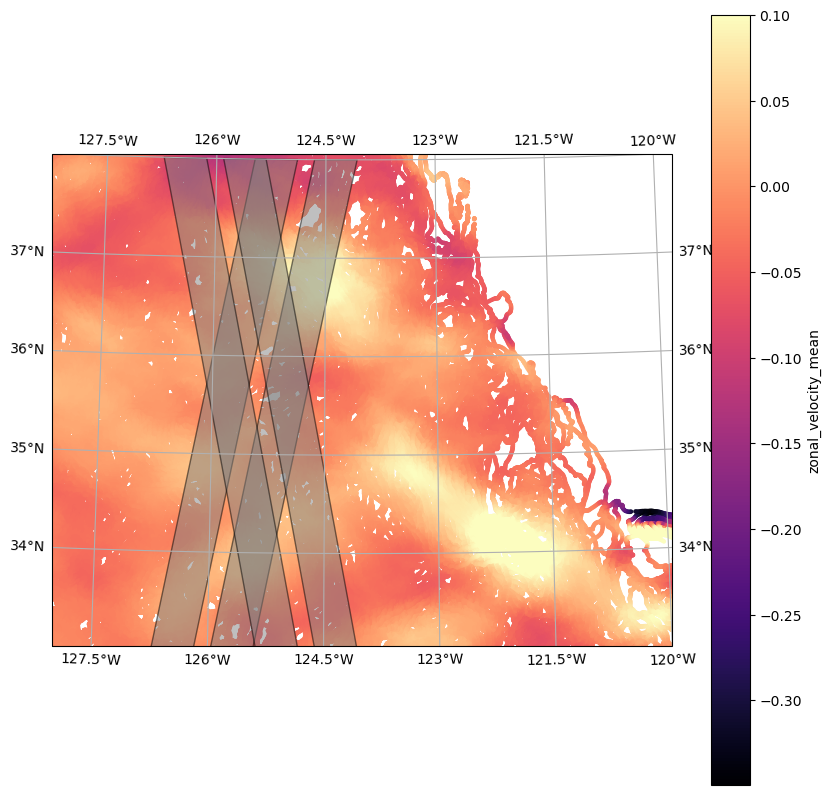

In [88]:
import geopandas as gdp
colmap='magma'
plot_swot(df,'zonal_velocity_mean',bbox,0.1,colmap,figsize=(5,5))

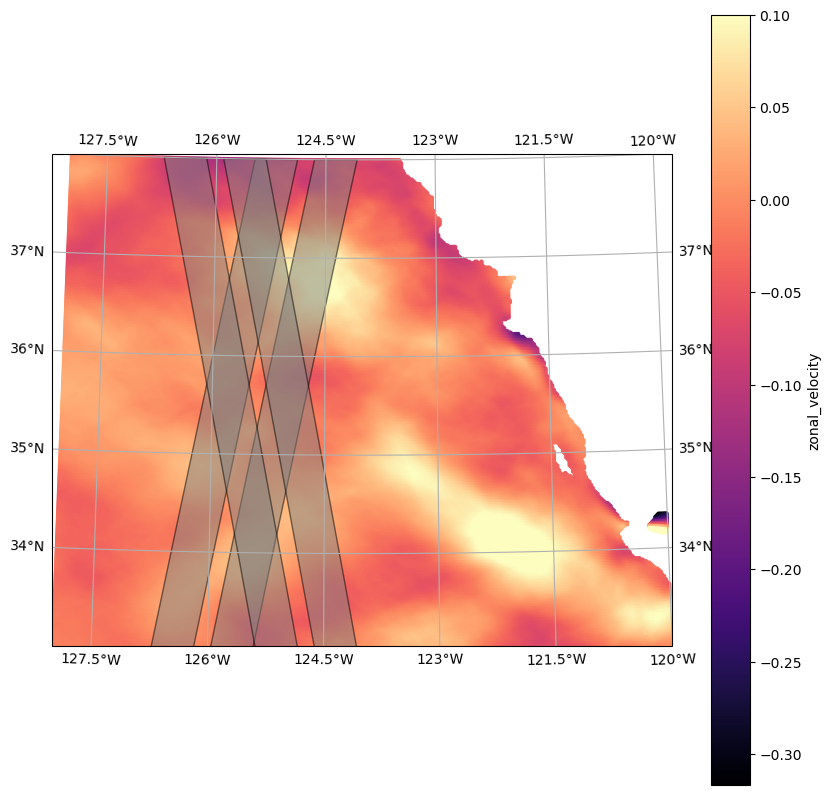

In [92]:
colmap='magma'
plot_swot(ds_mean.drop(['face']).to_dataframe(),'zonal_velocity',bbox,0.1,colmap)

Text(0.5, 0.98, 'Scatter plot')

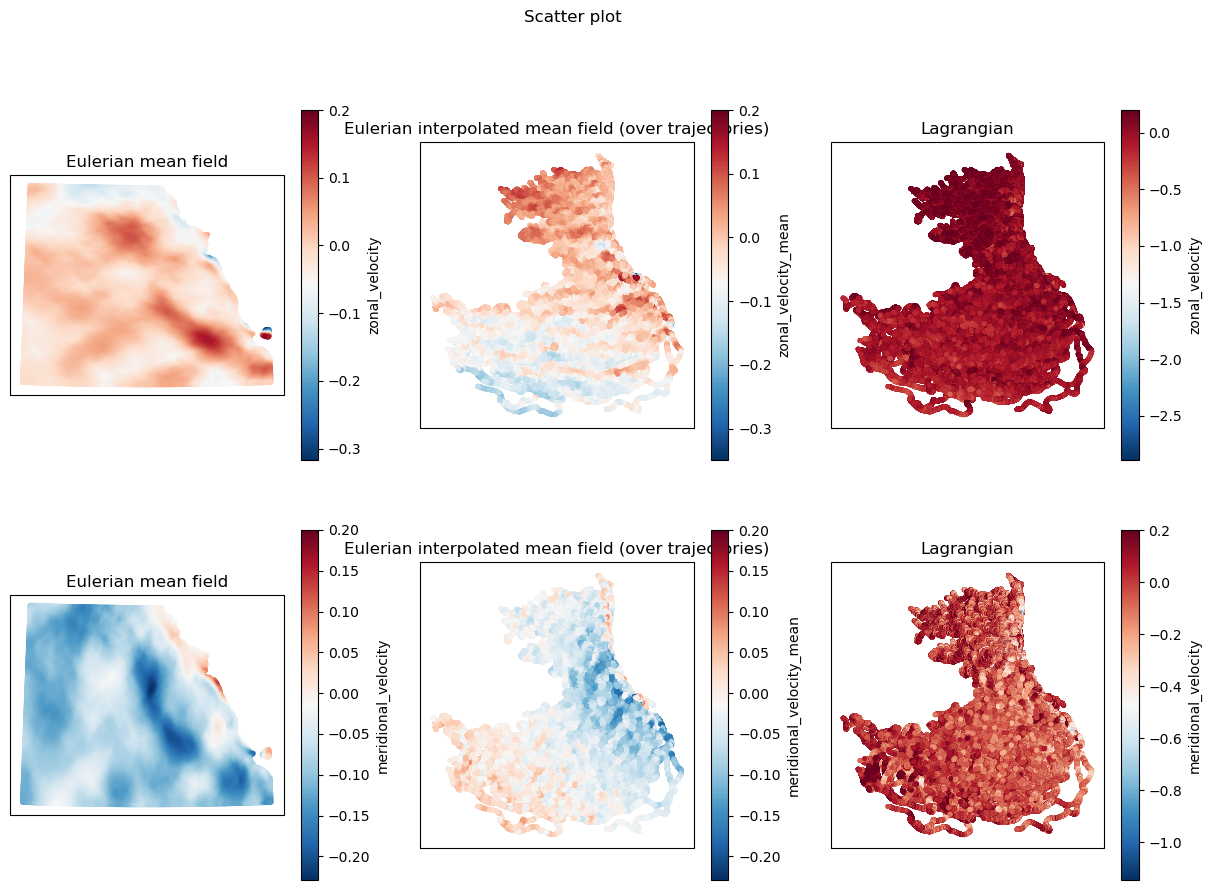

In [98]:
central_lon = (bbox[0]+bbox[1])*0.5
central_lat = (bbox[2]+bbox[3])*0.5

polygon = Polygon([(bbox[0], bbox[2]), 
                       (bbox[1], bbox[2]), 
                       (bbox[1], bbox[3]), 
                       (bbox[0], bbox[3]), 
                       (bbox[0], bbox[2]),
                      ])
    #poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=world.crs)
gdf = tracks["swath"]
gdf_clipped = gpd.clip(gdf, polygon)

#crs = ccrs.Orthographic(central_lon, central_lat)
crs = ccrs.AlbersEqualArea(central_lon, central_lat)

crs_proj4 = crs.proj4_init

fig, axs = plt.subplots(2, 3, 
                           subplot_kw={'projection': crs},
                           figsize=(15,10),
                          )
for i,V in enumerate(['zonal_velocity','meridional_velocity']):
    ds_mean.drop(['face']).to_dataframe().plot.scatter(x='lon',y='lat',c=V,cmap='RdBu_r',ax=axs[i,0],s=6,vmax=0.2,transform=ccrs.PlateCarree())
    df.plot.scatter(x='lon',y='lat',c=V+'_mean',cmap='RdBu_r',ax=axs[i,1],s=6,vmax=0.2,transform=ccrs.PlateCarree())
    df.plot.scatter(x='lon',y='lat',c=V,cmap='RdBu_r',ax=axs[i,2],s=6,vmax=0.2,transform=ccrs.PlateCarree())

    for title,ax in zip(['Eulerian mean field','Eulerian interpolated mean field (over trajectories)','Lagrangian'],axs[i,:]):
        ax.set_title(title)
fig.suptitle('Scatter plot')

In [107]:
dfE_mean

<xarray.Dataset>
Dimensions:              (lat: 0, lon: 0)
Coordinates:
  * lat                  (lat) float64 
  * lon                  (lon) float64 
Data variables:
    SSU                  (lon, lat) float64 
    SSV                  (lon, lat) float64 
    meridional_velocity  (lon, lat) float64 
    zonal_velocity       (lon, lat) float64

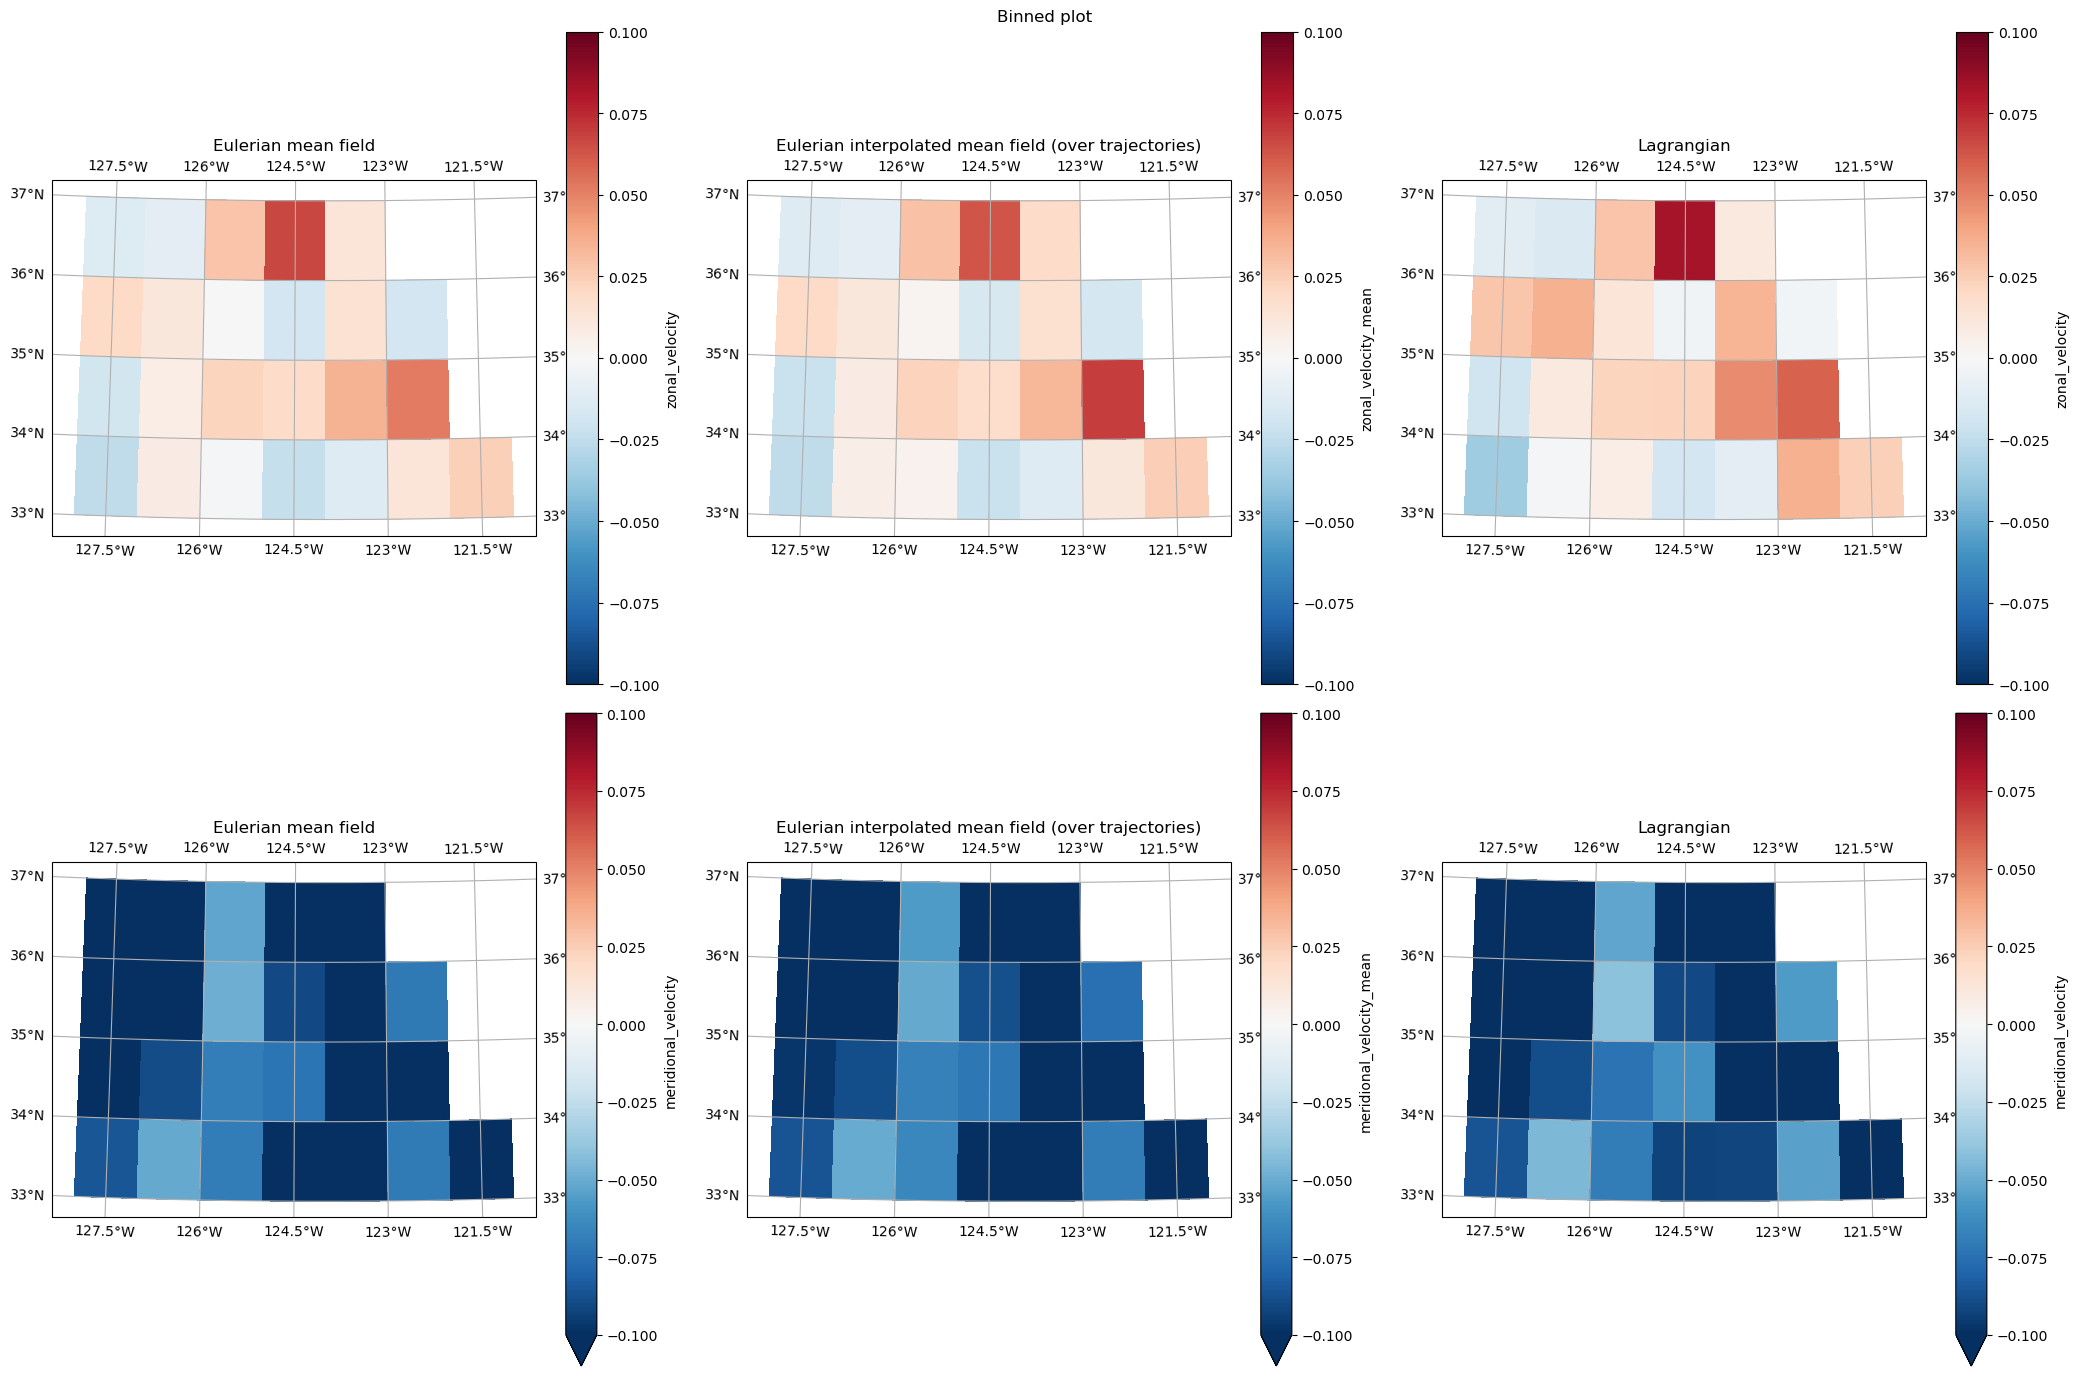

In [118]:
vmax = 0.1


central_lon = (bbox[0]+bbox[1])*0.5
central_lat = (bbox[2]+bbox[3])*0.5

polygon = Polygon([(bbox[0], bbox[2]), 
                       (bbox[1], bbox[2]), 
                       (bbox[1], bbox[3]), 
                       (bbox[0], bbox[3]), 
                       (bbox[0], bbox[2]),
                      ])
    #poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=world.crs)
gdf = tracks["swath"]
gdf_clipped = gpd.clip(gdf, polygon)

#crs = ccrs.Orthographic(central_lon, central_lat)
crs = ccrs.AlbersEqualArea(central_lon, central_lat)

crs_proj4 = crs.proj4_init

fig, axs = plt.subplots(2, 3, 
                           subplot_kw={'projection': crs},
                           figsize=(21,14),
                          )
for i,V in enumerate(['zonal_velocity','meridional_velocity']):
    dfE_mean[V].plot(x='lon',y='lat',cmap='RdBu_r',ax=axs[i,0],vmax=vmax,transform=ccrs.PlateCarree())
    dfL_mean[V+'_mean'].plot(x='lon',y='lat',cmap='RdBu_r',ax=axs[i,1],vmax=vmax,transform=ccrs.PlateCarree())
    dfL_mean[V].plot(x='lon',y='lat',cmap='RdBu_r',ax=axs[i,2],vmax=vmax,transform=ccrs.PlateCarree())

    for title,ax in zip(['Eulerian mean field','Eulerian interpolated mean field (over trajectories)','Lagrangian'],axs[i,:]):
        ax.set_title(title)
        ax.gridlines(draw_labels=True)
fig.suptitle('Binned plot')
fig.tight_layout()

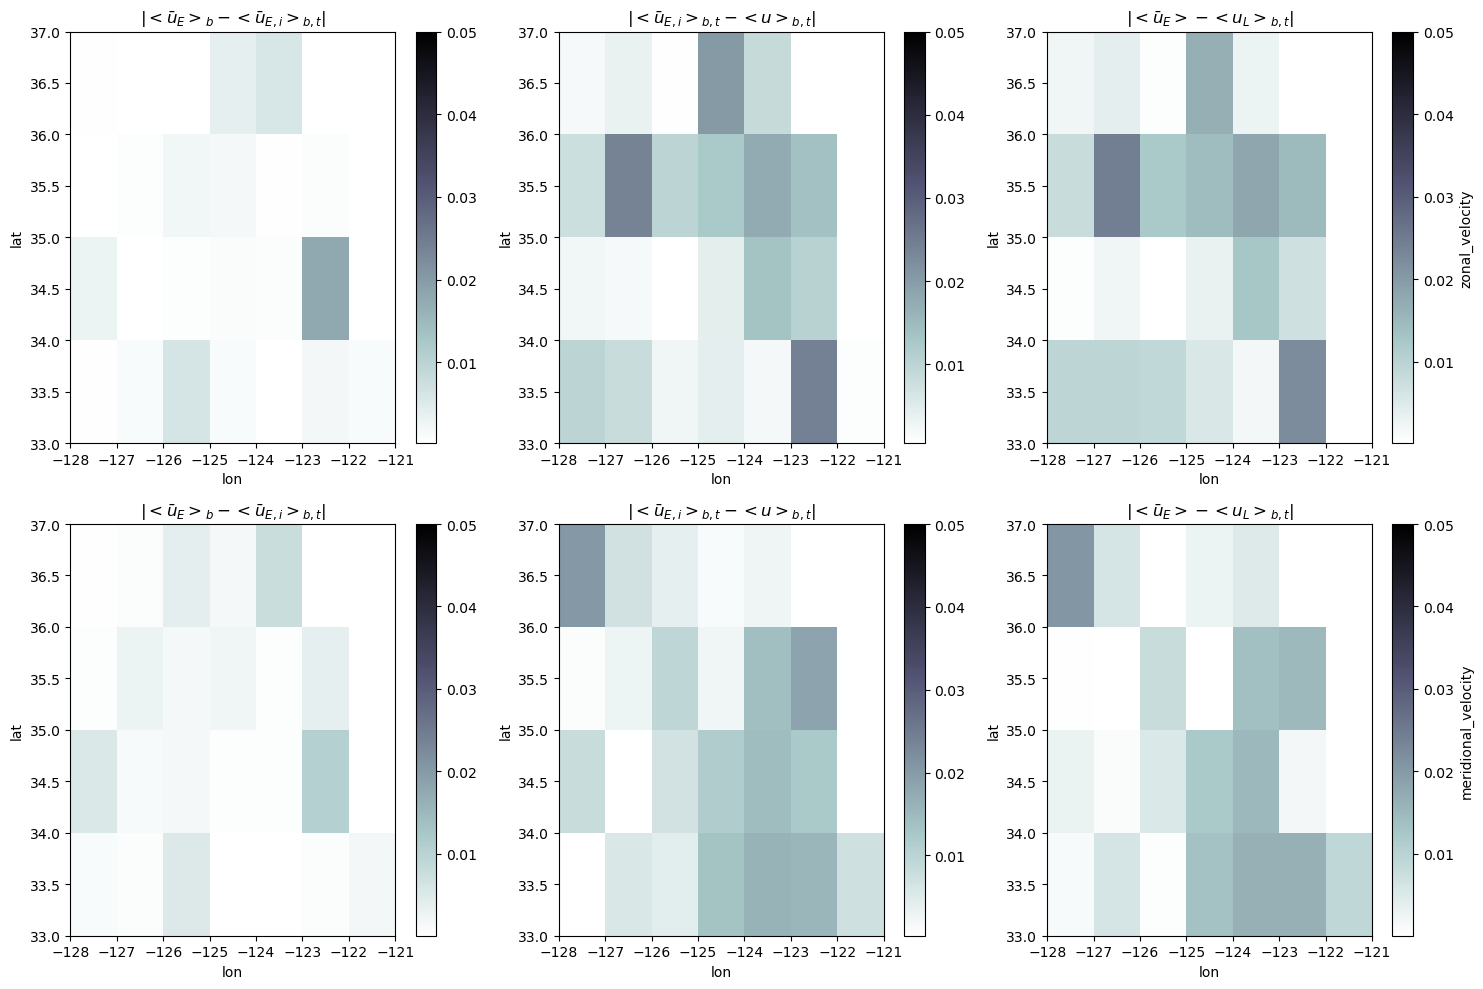

In [123]:
cmap='bone_r'
fig, axs = plt.subplots(2,3,figsize=(15,10))
for i,V in enumerate(['zonal_velocity','meridional_velocity']):
    np.abs(dfE_mean[V]-dfL_mean[V+'_mean']).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,0],vmax=0.05)
    np.abs(dfL_mean[V+'_mean']-dfL_mean[V]).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,1],vmax=0.05)
    np.abs(dfE_mean[V]-dfL_mean[V]).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,2],vmax=0.05)

    for title,ax in zip([r'$\vert <\bar u_E>_b-<\bar u_{E,i}>_{b,t}\vert$',r'$\vert <\bar u_{E,i}>_{b,t}-<u>_{b,t}\vert$',r'$\vert<\bar u_E>-<u_L>_{b,t}\vert$'],axs[i,:]):
        ax.set_title(title)

fig.tight_layout()
#fig,ax = plt.subplots(1,3,figsize=(15,5))
#df_count.plot(y='lat',ax=ax[0])
#dfL_1dl['count'].plot(y='lat',ax=ax[1])
#dfL_1dl['count']/dfE_1dl['count']).plot(y='lat',ax=ax[2])
#fig.tight_layout()

### Mean square

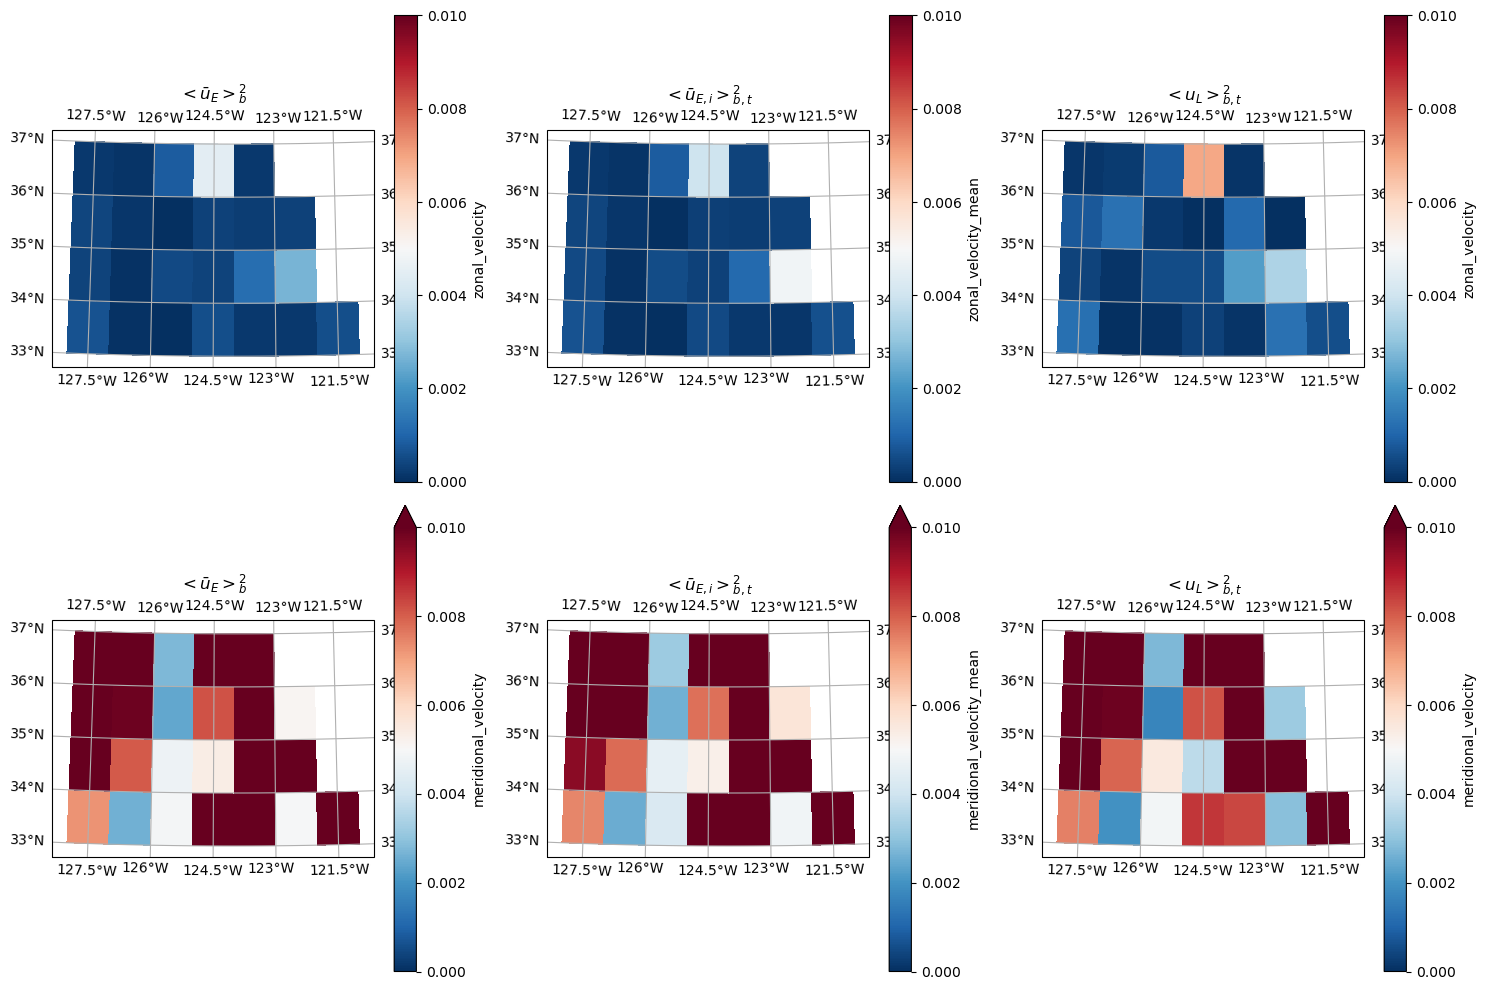

In [130]:
vmax = 0.01
central_lon = (bbox[0]+bbox[1])*0.5
central_lat = (bbox[2]+bbox[3])*0.5

polygon = Polygon([(bbox[0], bbox[2]), 
                       (bbox[1], bbox[2]), 
                       (bbox[1], bbox[3]), 
                       (bbox[0], bbox[3]), 
                       (bbox[0], bbox[2]),
                      ])
    #poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=world.crs)
gdf = tracks["swath"]
gdf_clipped = gpd.clip(gdf, polygon)

#crs = ccrs.Orthographic(central_lon, central_lat)
crs = ccrs.AlbersEqualArea(central_lon, central_lat)

crs_proj4 = crs.proj4_init

fig, axs = plt.subplots(2, 3, 
                           subplot_kw={'projection': crs},
                           figsize=(15,10),
                          )
for i,V in enumerate(['zonal_velocity','meridional_velocity']):
    (dfE_mean[V]**2).plot(x='lon',y='lat',cmap='RdBu_r',ax=axs[i,0],vmax=vmax,vmin=0,transform=ccrs.PlateCarree())
    (dfL_mean[V+'_mean']**2).plot(x='lon',y='lat',cmap='RdBu_r',ax=axs[i,1],vmax=vmax,vmin=0,transform=ccrs.PlateCarree())
    (dfL_mean[V]**2).plot(x='lon',y='lat',cmap='RdBu_r',ax=axs[i,2],vmax=vmax,vmin=0,transform=ccrs.PlateCarree())

    for title,ax in zip([r'$<\bar u_E>_{b}^2$',r'$<\bar u_{E,i}>_{b,t}^2$',r'$<u_L>_{b,t}^2$'],axs[i,:]):
        ax.set_title(title)
        ax.gridlines(draw_labels=True)

        
fig.tight_layout()

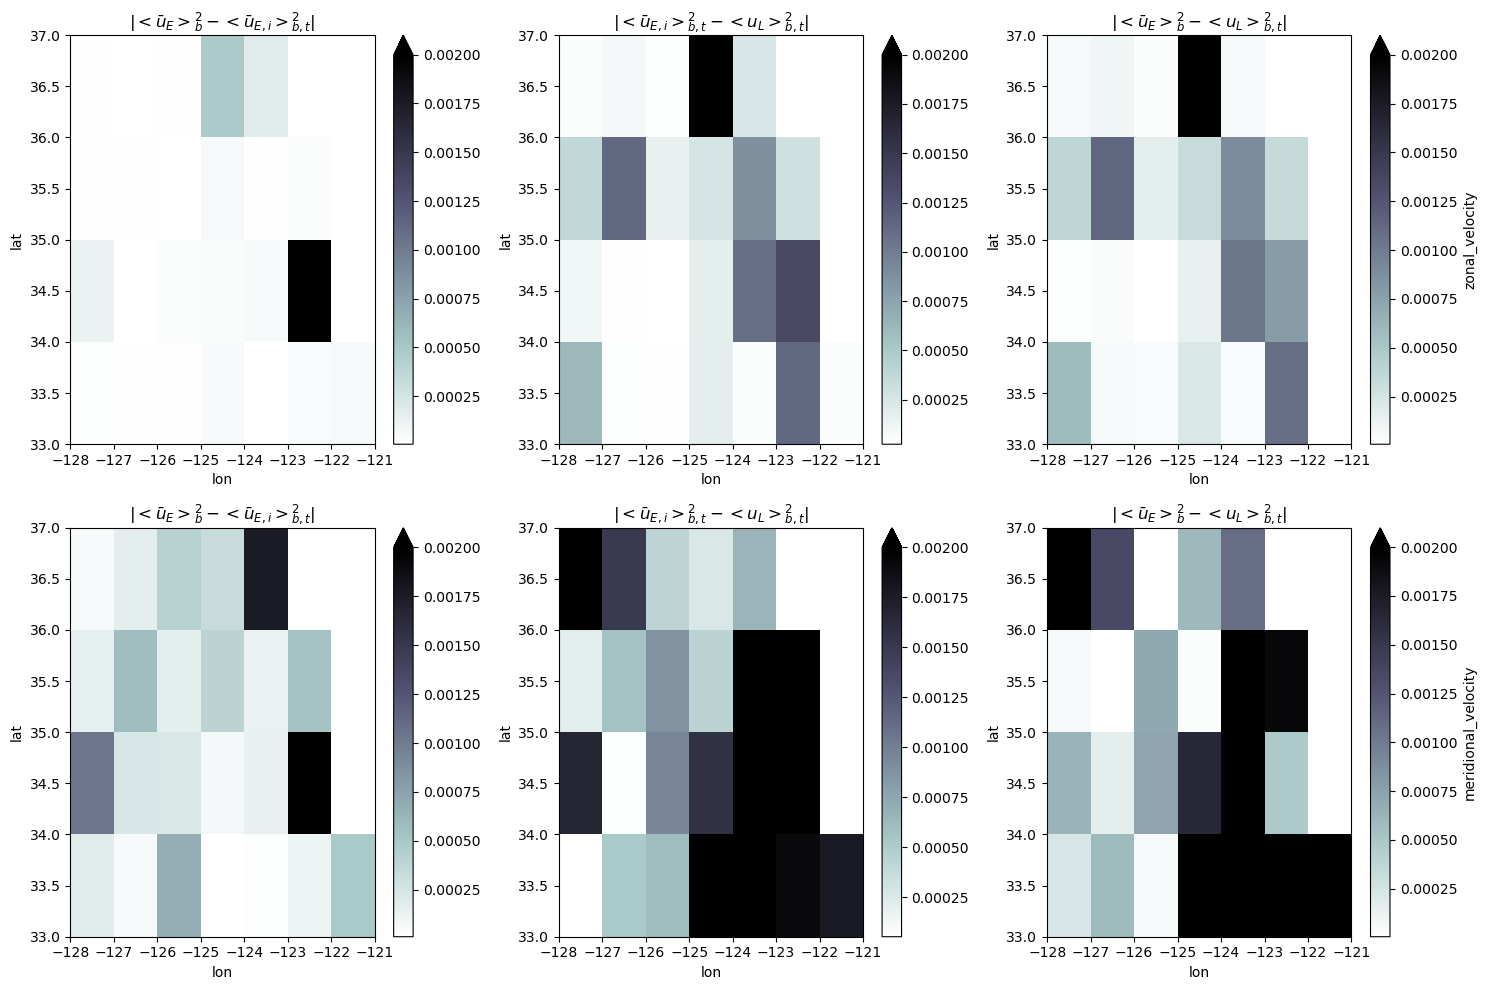

In [136]:
cmap='bone_r'
fig, axs = plt.subplots(2,3,figsize=(15,10))
for i,V in enumerate(['zonal_velocity','meridional_velocity']):
    np.abs(dfE_mean[V]**2-dfL_mean[V+'_mean']**2).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,0],vmax=0.002)
    np.abs(dfL_mean[V+'_mean']**2-dfL_mean[V]**2).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,1],vmax=0.002)
    np.abs(dfE_mean[V]**2-dfL_mean[V]**2).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,2],vmax=0.002)

    for title,ax in zip([r'$\vert <\bar u_E>_b^2-<\bar u_{E,i}>_{b,t}^2\vert$',r'$\vert <\bar u_{E,i}>_{b,t}^2-<u_L>_{b,t}^2\vert$',r'$\vert<\bar u_E>_b^2-<u_L>_{b,t}^2\vert$'],axs[i,:]):
        ax.set_title(title)

fig.tight_layout()

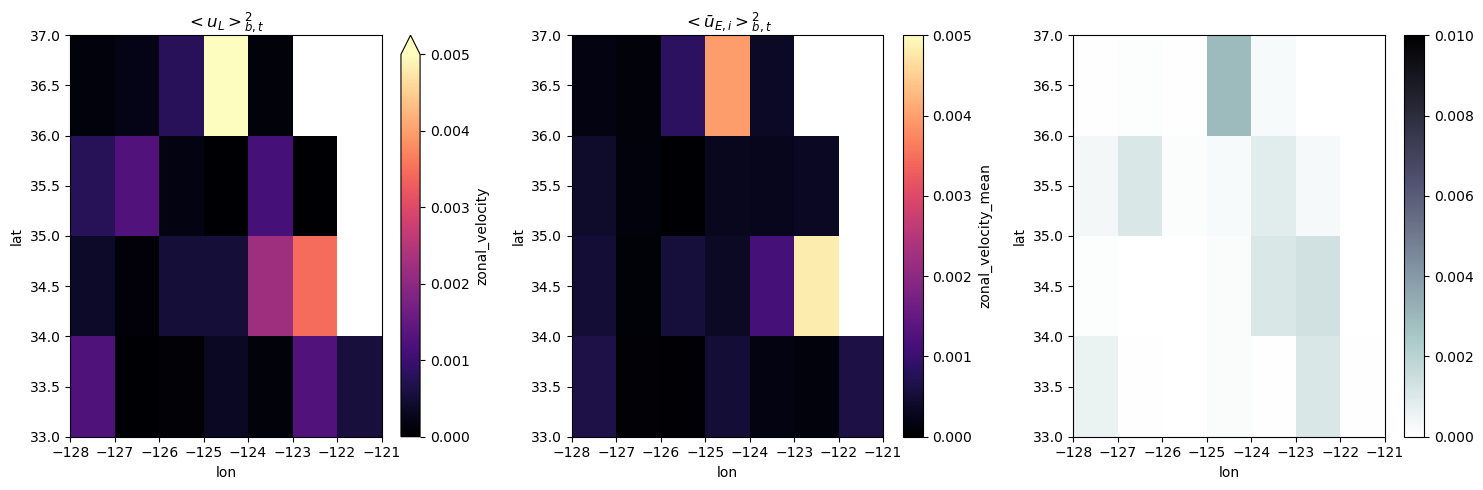

In [75]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
for V,ax,title in zip(['','_mean'],axs[:-1],[r'$<u_L>_{b,t}^2$',r'$<\bar u_{E,i}>_{b,t}^2$']):
    (dfL_mean['zonal_velocity'+V]**2).plot(y='lat',cmap='magma',ax=ax,vmax=0.005,vmin=0)
    ax.set_title(title)
np.abs((dfL_mean['zonal_velocity']**2)-(dfL_mean['zonal_velocity_mean']**2)).plot(y='lat',cmap='bone_r',ax=axs[-1],vmin=0,vmax=0.01)
fig.tight_layout()

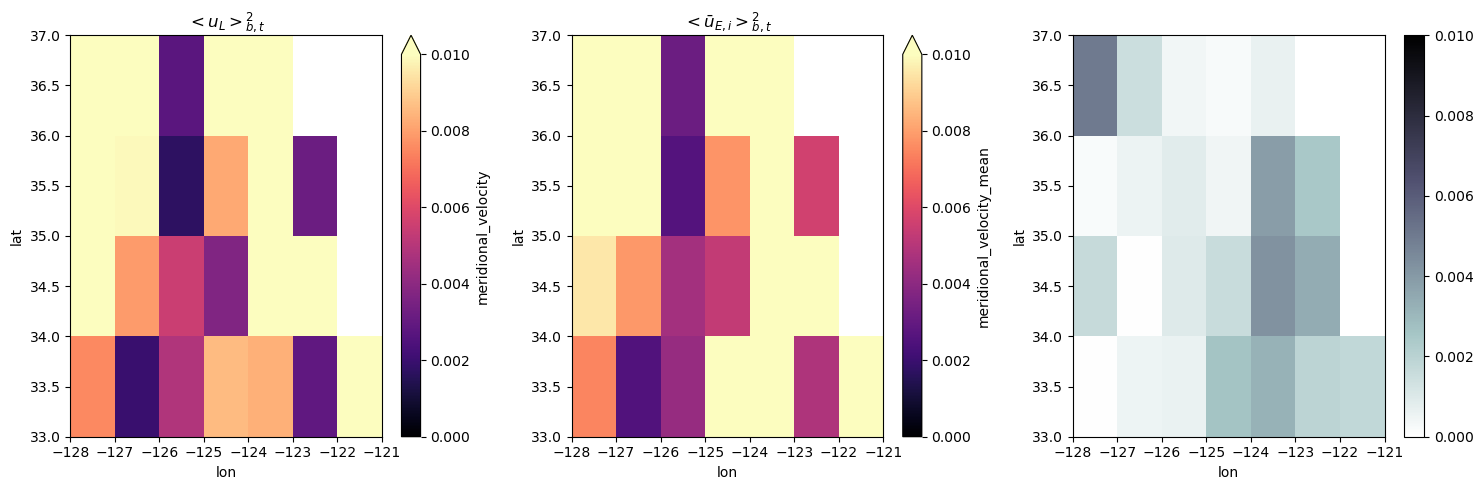

In [77]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
for V,ax,title in zip(['','_mean'],axs[:-1],[r'$<u_L>_{b,t}^2$',r'$<\bar u_{E,i}>_{b,t}^2$']):
    (dfL_mean['meridional_velocity'+V]**2).plot(y='lat',cmap='magma',ax=ax,vmax=0.01,vmin=0)
    ax.set_title(title)
np.abs((dfL_mean['meridional_velocity']**2)-(dfL_mean['meridional_velocity_mean']**2)).plot(y='lat',cmap='bone_r',ax=axs[-1],vmin=0,vmax=0.01)
fig.tight_layout()

### Variance

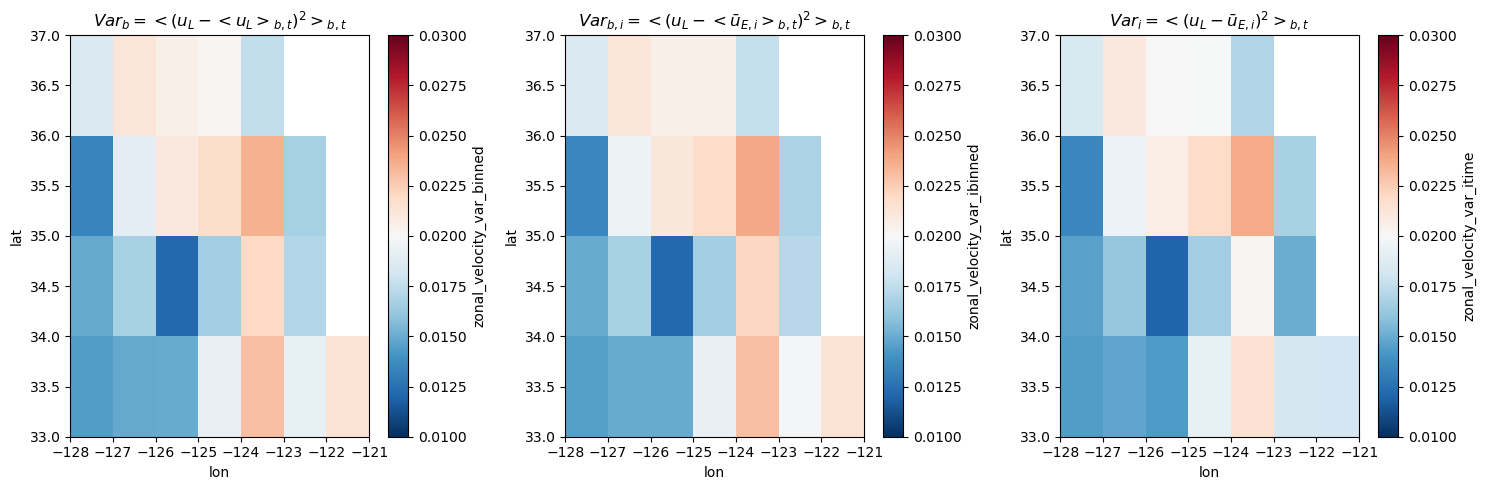

In [29]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
for V,ax,title in zip(['binned','ibinned','itime'],axs,[r'$Var_b = <(u_L-<u_{L}>_{b,t})^2>_{b,t}$',r'$Var_{b,i} = <(u_L-<\bar u_{E,i}>_{b,t})^2>_{b,t}$',r'$Var_i = <(u_L-\bar u_{E,i})^2>_{b,t}$']):
    dfL_mean['zonal_velocity_var_'+V].plot(y='lat',cmap='RdBu_r',ax=ax,vmax=0.03,vmin=0.01)
    ax.set_title(title)
fig.tight_layout()

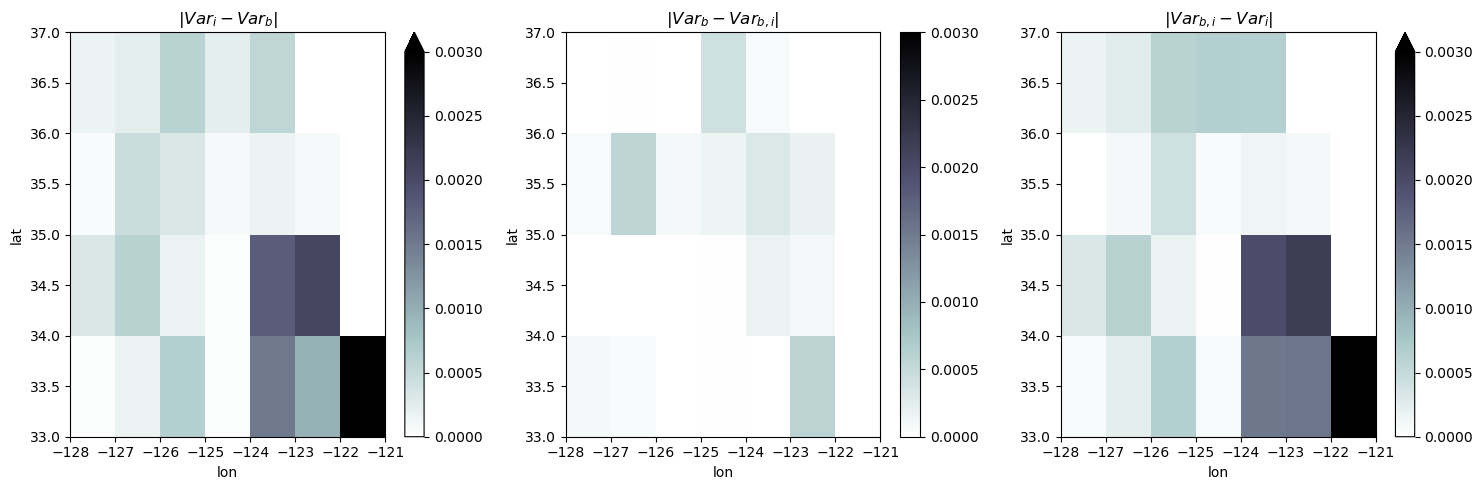

In [31]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
v = 'itime'
for V,ax,title in zip(['binned','ibinned','itime'],axs,[r'$\vert Var_i-Var_b\vert$',r'$\vert Var_b-Var_{b,i}\vert$',r'$\vert Var_{b,i}-Var_i\vert$']):
    np.abs(dfL_mean['zonal_velocity_var_'+v]-dfL_mean['zonal_velocity_var_'+V]).plot(y='lat',cmap='bone_r',ax=ax,vmin=0,vmax=0.003)
    ax.set_title(title)
    v=V
    
fig.tight_layout()

#### Notes : 
As expected the difference between varianc using binned and interpolated binned velocity is lower than the other differences

In [137]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
